In [135]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [136]:
words = open('names.txt','r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [137]:
words = open('names.txt','r').read().splitlines()
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.']=0
itos = {i:s for s,i in stoi.items()}
    

In [102]:
#build the dataset

block_size = 3 #context length: how many characters do we take to predict the next one
X,Y = [],[]
for w in words:
    #print(w)
    context = [0] * block_size
    for ch in w  + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        #print(''.join(itos[i] for i in context),'----->',itos[ix])
        context = context[1:] + [ix]  #crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [6]:
#embedding lookup table

C = torch.randn((27,2)) # Each character will have a two dimensional embedding
emb = C[X]

tensor stores the matrix in one dimensionl use .storage()

to get another shape we just need to write .view(shape you desire)

In [7]:
#implementing hidden layers
W1 = torch.randn((6,100))
b1 = torch.randn(100)

In [12]:
h = torch.tanh(emb.view(-1,6) @ W1 +b1)

In [13]:
h.shape

torch.Size([32, 100])

In [14]:
W2 = torch.randn((100,27))
b2 = torch.randn(27)

In [15]:
logits = h @ W2 + b2

In [17]:
logits.shape

torch.Size([32, 27])

we convert logits to probability by first converting them to values between 0 and 1 using exp then sum columns for each row by dim=1 and keepdim=True, then we divide the counts by sum of the row and we end up with "probabilites"

In [21]:
counts = logits.exp()
prob = counts/counts.sum(1,keepdim=True)
prob.shape

torch.Size([32, 27])

we get the probability for the correct next character from the prob matrix

In [23]:
prob[torch.arange(32),Y].log().mean()  #negative log likelihood

tensor(-12.6630)

Cleaning up the code and using F.cross_entropy() instead of counting and calculating probabilities, using cross_entropy() is faster and doesn't create new tensors saving memory, using exp to convert to counts can be harmful as it tends to inf when large positive number, so cross entropy prevents this is by subtracting the largest positive number making them all negative therefore preventing explosion, and it also makes the forward and backward pass efficient

In [45]:
X.shape,Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [68]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2),generator=g)
W1 = torch.randn((6,100),generator=g)
b1 = torch.randn((100),generator=g)
W2 = torch.randn((100,27),generator=g)
b2 = torch.randn(27,generator=g)
parameters=[C,W1,b1,W2,b2]

In [47]:
sum(p.nelement() for p in parameters)  # total number of parameters in total

3481

In [69]:
for p in parameters:
    p.requires_grad = True

In [51]:
for _ in range(10):
    #forward pass
    emb =C[X]
    h = torch.tanh(emb.view(-1,6)@W1+b1)
    logits = h @ W2 + b2           
    loss = F.cross_entropy(logits,Y)
    print(loss.item())
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    #update
    for p in parameters:
        p.data += -0.1 * p.grad


8.329227447509766
8.144325256347656
7.966792106628418
7.796451568603516
7.633185863494873
7.476909160614014
7.327521800994873
7.184886455535889
7.048792839050293
6.918953895568848


The loss will never be exactly zero as the context ... has many true answers and to judge one as correct will give a loss, but for one solution it overfits if we use a small dataset

Mini-batches

pick a random batch from X and train the model on it, it will be quicker but because we are not using the entire dataset the quality of the gradient descent will be lower and will never reach global minima

torch.randint generates 32 random numbers between 0 and X.shape[0]

In [52]:
torch.randint(0,X.shape[0],(32,))

tensor([195628, 168884,  24701, 140751, 156908, 142971, 114982, 105181, 202278,
         37530, 216356,  30874,  78597, 158208, 204327, 152027,  88593, 192160,
        136567,  29743,  98055, 192092, 131285, 163716,  16611,  56586,   9822,
         75666, 121655, 200629,  75053,  38338])

generate 1000 learning rates between 0.001 and 1 and test which one works best  -> selecting the best learning rate

In [103]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2),generator=g)
W1 = torch.randn((6,100),generator=g)
b1 = torch.randn((100),generator=g)
W2 = torch.randn((100,27),generator=g)
b2 = torch.randn(27,generator=g)
parameters=[C,W1,b1,W2,b2]

In [104]:
for p in parameters:
    p.requires_grad = True

In [105]:
lre = torch.linspace(-3,0,1000)
lrs = 10**lre

In [111]:
lri = []
lossi = []
for i in range(10000):
    ix = torch.randint(0,X.shape[0],(32,))
    #forward pass
    emb =C[X][ix]
    h = torch.tanh(emb.view(-1,6)@W1+b1)
    logits = h @ W2 + b2           
    loss = F.cross_entropy(logits,Y[ix])
    #print(loss.item())
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    #update
    #lr = lrs[i]
    for p in parameters:
        p.data += -0.01 * p.grad
    
    #lri.append(lre[i])
    #lossi.append(loss.item())

#print(loss.item())


In [112]:
#plt.plot(lri,lossi)

the x axis is the exponent of the learning rate 

In [113]:
emb =C[X]
h = torch.tanh(emb.view(-1,6)@W1+b1)
logits = h @ W2 + b2           
loss = F.cross_entropy(logits,Y)
loss.item()

2.356499433517456

First find a decent learning rate, train the algo for a while then lower the learning rate

Splitting the dataset into training,dev,test split

In [142]:
words = open('names.txt','r').read().splitlines()
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.']=0
itos = {i:s for s,i in stoi.items()}

In [143]:
#build the dataset

def build_dataset(words):
    block_size = 3 #context length: how many characters do we take to predict the next one
    X,Y = [],[]
    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w  + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context),'----->',itos[ix])
            context = context[1:] + [ix]  #crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape,Y.shape)
    return X,Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2= int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev,Ydev = build_dataset(words[n1:n2])
Xte,Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


experiment 1 : increasing the size of the first hidden layer from 100 to 300
experiment 2 : increasing the embedding size from 2 to 10

In [144]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,10),generator=g)
W1 = torch.randn((30,200),generator=g) #previously 100 neurons i
b1 = torch.randn((200),generator=g)
W2 = torch.randn((200,27),generator=g)
b2 = torch.randn(27,generator=g)
parameters=[C,W1,b1,W2,b2]
for p in parameters:
    p.requires_grad = True

In [145]:
stepi = []
lossi = []

In [146]:

for i in range(50000):
    ix = torch.randint(0,Xtr.shape[0],(32,))
    #forward pass
    emb =C[Xtr][ix]
    h = torch.tanh(emb.view(-1,30)@W1+b1)
    logits = h @ W2 + b2           
    loss = F.cross_entropy(logits,Ytr[ix])
    #print(loss.item())
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    #update
    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad
    stepi.append(i)
    lossi.append(loss.log10().item())

#print(loss.item())


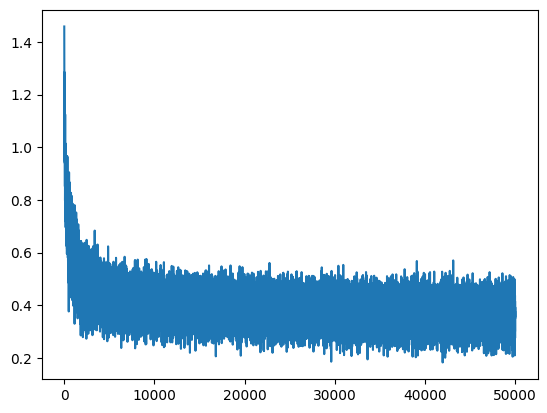

In [147]:
plt.plot(stepi,lossi)

In [148]:
emb =C[Xtr]
h = torch.tanh(emb.view(-1,30)@W1+b1)
logits = h @ W2 + b2           
loss = F.cross_entropy(logits,Ytr)
loss.item()

2.3311777114868164

In [149]:
emb =C[Xdev]
h = torch.tanh(emb.view(-1,30)@W1+b1)
logits = h @ W2 + b2           
loss = F.cross_entropy(logits,Ydev)
loss.item()

2.3523733615875244

if training loss = dev loss -> not overfitting i.e. model is not memorizing everything

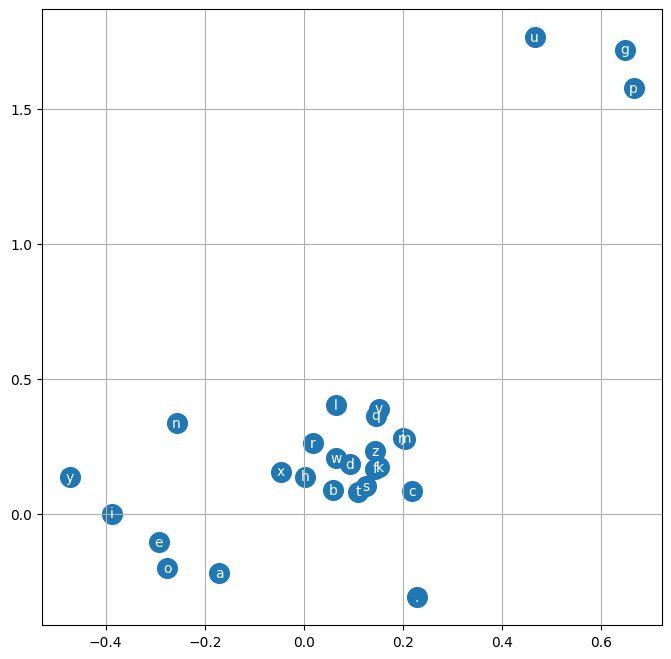

In [130]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data,C[:,1].data,s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(),C[i,1].item(),itos[i],ha="center",va="center",color='white')
plt.grid('minor')

above will plot the 27 characters on the embedding space according to the C matrix(when it was embedded in two dimension)

In [154]:
g = torch.Generator().manual_seed(2147483647)

for _ in range(10):
    out=[]
    context=[0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1,-1)@W1+b1)
        logits = h@W2+b2
        probs = F.softmax(logits,dim=1)
        ix = torch.multinomial(probs,num_samples=1,generator=g).item()
        out.append(ix)
        context = context[1:]+[ix]
        if ix==0:
            break
    
    print(''.join(itos[i] for i in out))


manide.
makaiah.
parsay.
adria.
sirritone.
amaree.
kalina.
myra.
levias.
dedainr.
